# 타이타닉 생존자 예측

## 1. 라이브러리 및 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from google.colab import drive

from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.chdir('/content/drive/MyDrive/data/Titanic')
sys.path.append(os.chdir)

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

## 2. 데이터 분석
    PassengerId : 탑승객의 고유 아이디
    Survival : 생존여부(0: 사망, 1: 생존)
    Pclass : 등실의 등급(1: 1등급, 2: 2등급, 3: 3등급)
    Name : 이름
    Sex : 성별
    Age : 나이
    Sibsp : 함께 탑승한 형제자매, 아내 남편의 수
    Parch: 함께 탑승한 부모, 자식의 수
    Ticket: 티켓번호
    Fare: 티켓의 요금
    Cabin: 객실번호
    Embarked: 배에 탑승한 위치(C = Cherbourg, Q = Queenstown, S = Southampton)

In [5]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
train[['Pclass', 'Ticket']].head(20)

,Pclass,Ticket
0,3,A/5 21171
1,1,PC 17599
2,3,STON/O2. 3101282
3,1,113803
4,3,373450
5,3,330877
6,1,17463
7,3,349909
8,3,347742
9,2,237736


Ticket 번호 첫번째 숫자가 객실의 등급과 대부분 동일한것으로 보임.<br/>
Ticket에 대해서는 유의미한 정보가 없다 판단되어 삭제하기로 생각함<br/>
대충 봤을 땐 Ticket이 Pclass에 포함된것 같고, Name이 Sex에 포함된거같음<br/>
Name도 삭제하기로 판단

In [8]:
train = train.drop(['PassengerId', 'Name', 'Ticket'], axis=1)
test = test.drop(['PassengerId', 'Name', 'Ticket'], axis=1)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Cabin     204 non-null    object 
 8   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 62.8+ KB


In [10]:
train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [11]:
train['Sex'].unique()

array(['male', 'female'], dtype=object)

In [12]:
train['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [13]:
train['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

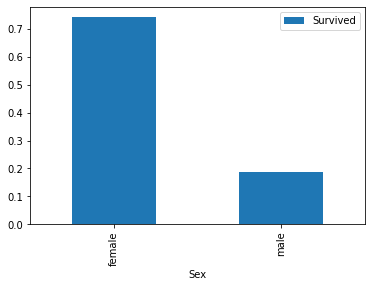

In [14]:
train[['Sex', 'Survived']].groupby('Sex').mean().plot(kind='bar')

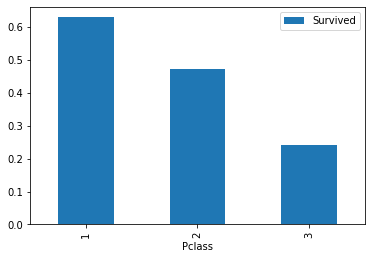

In [15]:
train[['Pclass', 'Survived']].groupby('Pclass').mean().plot(kind='bar')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb212557f90>,
      dtype=object)

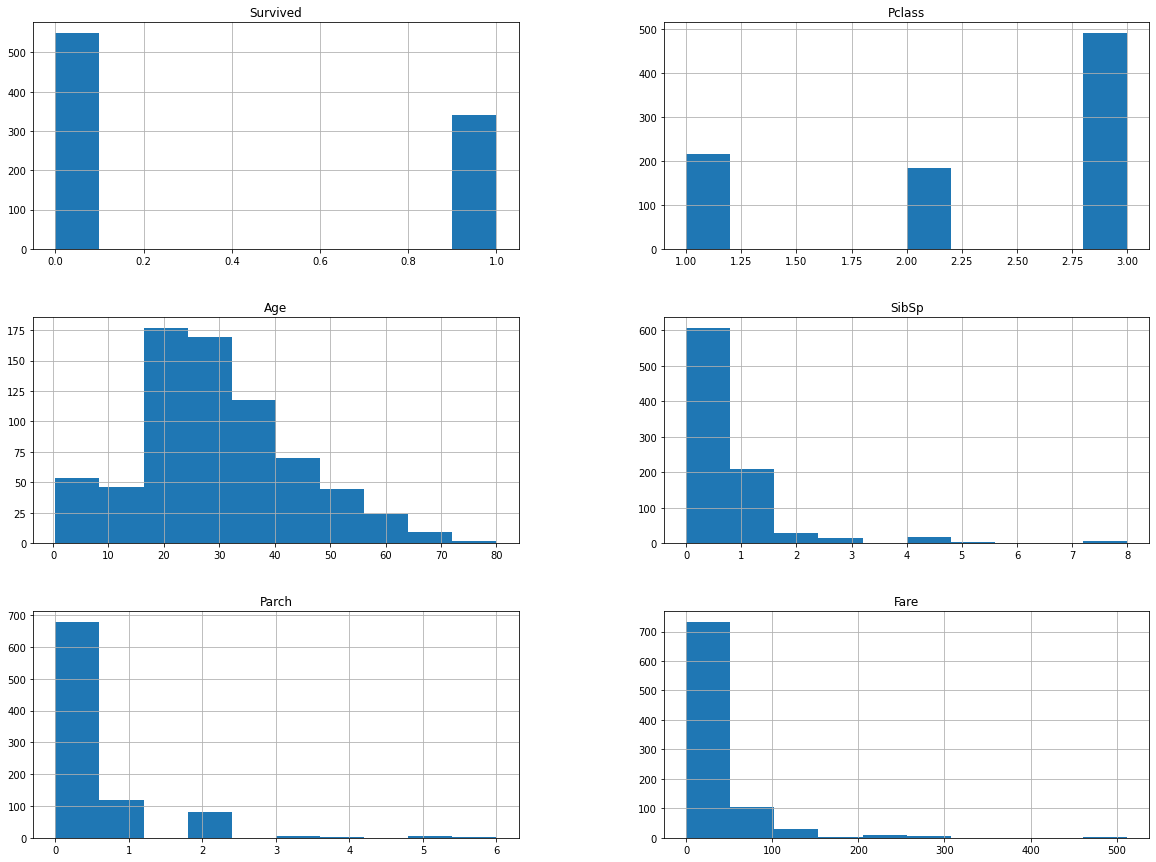

In [16]:
train.hist(bins=10, grid=True, figsize=(20,15))

## 3. 전처리

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Cabin     204 non-null    object 
 8   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 62.8+ KB


In [18]:
train[['Pclass', 'Age']].groupby('Pclass').mean()

,Age
Pclass,
1,38.233441
2,29.877630
3,25.140620


In [19]:
train_age_null = train[train.Age.isnull()]

train_firstclass = train_age_null[train_age_null.Pclass == 1]
train_second = train_age_null[train_age_null.Pclass == 2]
train_third = train_age_null[train_age_null.Pclass == 3]

In [20]:
train_firstclass = train_firstclass.fillna(value = '38')
train_secondclass = train_second.fillna(value = '30')
train_thirdclass = train_third.fillna(value = '25')

In [21]:
train_drop_na = train.dropna(subset = ['Age'])

In [22]:
train_concat = pd.concat([train_drop_na, train_firstclass, train_secondclass, train_thirdclass])
train = train_concat
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 888
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    object 
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Cabin     362 non-null    object 
 8   Embarked  889 non-null    object 
dtypes: float64(1), int64(4), object(4)
memory usage: 69.6+ KB


In [23]:
train = train.astype({'Age':'int'})
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 888
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    int64  
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Cabin     362 non-null    object 
 8   Embarked  889 non-null    object 
dtypes: float64(1), int64(5), object(3)
memory usage: 69.6+ KB


In [24]:
test_age_null = test[test.Age.isnull()]
# 결측값을 가지는 새로운 데이터 프레임을 생성한다.

# train_df.loc[train_df.Age.isnull() == True]&train_df
# 각 데이터를 1,2,3등급에 나누어서 
test_firstclass = test_age_null[test_age_null.Pclass == 1]
test_second = test_age_null[test_age_null.Pclass == 2]
test_third = test_age_null[test_age_null.Pclass == 3]

test_firstclass = test_firstclass.fillna(value = '38')
test_secondclass = test_second.fillna(value = '30')
test_thirdclass = test_third.fillna(value = '25')

# Age의 결측값을 포함하는 행을 삭제한다.
test_drop_na = test.dropna(subset = ['Age'])

#결측값을 제거한 테이블과 결측값을 포함하지 않는 테이블을 병합한다.
test_concat = pd.concat([test_drop_na, test_firstclass, test_secondclass, test_thirdclass])
test = test_concat

test = test.astype({'Age':'int'})
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   Age       418 non-null    int64  
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      417 non-null    float64
 6   Cabin     173 non-null    object 
 7   Embarked  418 non-null    object 
dtypes: float64(1), int64(4), object(3)
memory usage: 29.4+ KB


In [25]:
train["Embarked"].fillna('S', inplace=True)
test["Embarked"].fillna('S', inplace=True)

In [26]:
train[['Fare', 'Pclass']].groupby('Pclass').mean()

,Fare
Pclass,
1,84.154687
2,20.662183
3,13.675550


In [27]:
test[test['Fare'].isna()]

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
152,3,male,60,0,0,NaN,NaN,S


In [28]:
test['Fare'].fillna(value=14, inplace=True)

In [29]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   Age       418 non-null    int64  
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      418 non-null    float64
 6   Cabin     173 non-null    object 
 7   Embarked  418 non-null    object 
dtypes: float64(1), int64(4), object(3)
memory usage: 29.4+ KB


In [30]:
train = train.drop(['Cabin'], axis=1)
test = test.drop(['Cabin'], axis=1)

In [31]:
train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22,1,0,7.2500,S
1,1,1,female,38,1,0,71.2833,C
2,1,3,female,26,0,0,7.9250,S
3,1,1,female,35,1,0,53.1000,S
4,0,3,male,35,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
859,0,3,male,25,0,0,7.2292,C
863,0,3,female,25,8,2,69.5500,S
868,0,3,male,25,0,0,9.5000,S
878,0,3,male,25,0,0,7.8958,S


In [32]:
# pclass_train_dummies = pd.get_dummies(train['Pclass'])
# pclass_test_dummies = pd.get_dummies(test['Pclass'])

# train.drop(['Pclass'], axis=1, inplace=True)
# test.drop(['Pclass'], axis=1, inplace=True)

# pclass_train_dummies.columns = ['First', 'Second', 'Third']
# pclass_test_dummies.columns = ['First', 'Second', 'Third']

# train = train.join(pclass_train_dummies)
# test = test.join(pclass_test_dummies)

In [33]:
# sex_train_dummies = pd.get_dummies(train['Sex'])
# sex_test_dummies = pd.get_dummies(test['Sex'])

# sex_train_dummies.columns = ['Female', 'Male']
# sex_test_dummies.columns = ['Female', 'Male']

# train.drop(['Sex'], axis=1, inplace=True)
# test.drop(['Sex'], axis=1, inplace=True)

# train = train.join(sex_train_dummies)
# test = test.join(sex_test_dummies)

In [34]:
# embarked_train_dummies = pd.get_dummies(train['Embarked'])
# embarked_test_dummies = pd.get_dummies(test['Embarked'])

# embarked_train_dummies.columns = ['S', 'C', 'Q']
# embarked_test_dummies.columns = ['S', 'C', 'Q']

# train.drop(['Embarked'], axis=1, inplace=True)
# test.drop(['Embarked'], axis=1, inplace=True)

# train = train.join(embarked_train_dummies)
# test = test.join(embarked_test_dummies)

In [35]:
X_train = train.drop(['Survived'], axis=1)
y_train = train['Survived']
X_test = test

In [36]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

train_num = X_train[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']]
train_cat = X_train[['Sex','Embarked']]

num_pipeline = Pipeline([
                         ("imputer", SimpleImputer(strategy="median")),
                        #  ("std_scaler", StandardScaler())
                        ])


cat_pipeline = Pipeline([
                         ("onehot", OneHotEncoder(sparse=False))
                        ])

num_attribs = list(train_num)
cat_attribs = list(train_cat)

full_pipeline = ColumnTransformer([
                                    ('num', num_pipeline, num_attribs),
                                    ('cat', cat_pipeline, cat_attribs),
                                    ])

train_pre = full_pipeline.fit_transform(X_train)
test_pre = full_pipeline.transform(X_test)

train_pre = pd.DataFrame(train_pre)
test_pre = pd.DataFrame(test_pre)

train_pre.columns = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Female', 'Male', 'C', 'Q', 'S']
test_pre.columns = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Female', 'Male', 'C', 'Q', 'S']

In [37]:
train_pre.head()

,Pclass,Age,SibSp,Parch,Fare,Female,Male,C,Q,S
0,3.0,22.0,1.0,0.0,7.2500,0.0,1.0,0.0,0.0,1.0
1,1.0,38.0,1.0,0.0,71.2833,1.0,0.0,1.0,0.0,0.0
2,3.0,26.0,0.0,0.0,7.9250,1.0,0.0,0.0,0.0,1.0
3,1.0,35.0,1.0,0.0,53.1000,1.0,0.0,0.0,0.0,1.0
4,3.0,35.0,0.0,0.0,8.0500,0.0,1.0,0.0,0.0,1.0


In [38]:
test_pre.head()

,Pclass,Age,SibSp,Parch,Fare,Female,Male,C,Q,S
0,3.0,34.0,0.0,0.0,7.8292,0.0,1.0,0.0,1.0,0.0
1,3.0,47.0,1.0,0.0,7.0000,1.0,0.0,0.0,0.0,1.0
2,2.0,62.0,0.0,0.0,9.6875,0.0,1.0,0.0,1.0,0.0
3,3.0,27.0,0.0,0.0,8.6625,0.0,1.0,0.0,0.0,1.0
4,3.0,22.0,1.0,1.0,12.2875,1.0,0.0,0.0,0.0,1.0


In [39]:
# X_train = train.drop(['Survived'], axis=1)
# y_train = train['Survived']
# X_test = test

## 4. 모델 선택

In [40]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [41]:
model_svc = SVC(probability=True)

In [42]:
score = []

for trn_idx, val_idx in kfold.split(train_pre):

    X_trn, y_trn = train_pre.iloc[trn_idx,:], y_train.iloc[trn_idx]
    X_val, y_val = train_pre.iloc[val_idx,:], y_train.iloc[val_idx]

    model_svc.fit(X_trn, y_trn)

    y_pred = model_svc.predict_proba(X_val)[:,1]

    print("예측 완료")

    score.append(roc_auc_score(y_val.values, y_pred))

np.mean(score)

예측 완료
예측 완료
예측 완료
예측 완료
예측 완료


0.7515448963669324

In [43]:
model_lsvc = LinearSVC()

score = []

for trn_idx, val_idx in kfold.split(train_pre):

    X_trn, y_trn = train_pre.iloc[trn_idx,:], y_train.iloc[trn_idx]
    X_val, y_val = train_pre.iloc[val_idx,:], y_train.iloc[val_idx]

    model_lsvc.fit(X_trn, y_trn)

    y_pred = model_lsvc.predict(X_val)

    print("예측 완료")

    score.append(roc_auc_score(y_val.values, y_pred))

np.mean(score)

예측 완료
예측 완료
예측 완료
예측 완료
예측 완료


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


0.6934646697494806

In [44]:
model_knc = KNeighborsClassifier()

score = []

for trn_idx, val_idx in kfold.split(X_train):

    X_trn, y_trn = X_train.iloc[trn_idx,:], y_train.iloc[trn_idx]
    X_val, y_val = X_train.iloc[val_idx,:], y_train.iloc[val_idx]

    model_knc.fit(X_trn, y_trn)

    y_pred = model_knc.predict_proba(X_val)[:,1]

    print("예측 완료")

    score.append(roc_auc_score(y_val.values, y_pred))

np.mean(score)

ValueError: ignored

In [ ]:
model_dt = DecisionTreeClassifier()

score = []

for trn_idx, val_idx in kfold.split(X_train):

    X_trn, y_trn = X_train.iloc[trn_idx,:], y_train.iloc[trn_idx]
    X_val, y_val = X_train.iloc[val_idx,:], y_train.iloc[val_idx]

    model_dt.fit(X_trn, y_trn)

    y_pred = model_dt.predict_proba(X_val)[:,1]

    print("예측 완료")

    score.append(roc_auc_score(y_val.values, y_pred))

np.mean(score)

In [ ]:
model_rf = RandomForestClassifier()

score = []

for trn_idx, val_idx in kfold.split(train_pre):

    X_trn, y_trn = train_pre.iloc[trn_idx,:], y_train.iloc[trn_idx]
    X_val, y_val = train_pre.iloc[val_idx,:], y_train.iloc[val_idx]

    model_rf.fit(X_trn, y_trn)

    y_pred = model_rf.predict_proba(X_val)[:,1]

    print("예측 완료")

    score.append(roc_auc_score(y_val.values, y_pred))

np.mean(score)

In [ ]:
model_lgbm = LGBMClassifier()

score = []

for trn_idx, val_idx in kfold.split(train_pre):

    X_trn, y_trn = train_pre.iloc[trn_idx,:], y_train.iloc[trn_idx]
    X_val, y_val = train_pre.iloc[val_idx,:], y_train.iloc[val_idx]

    model_lgbm.fit(X_trn, y_trn)

    y_pred = model_lgbm.predict_proba(X_val)[:,1]

    print("예측 완료")

    score.append(roc_auc_score(y_val.values, y_pred))

np.mean(score)

In [ ]:
model_xgb = XGBClassifier()

score = []

for trn_idx, val_idx in kfold.split(train_pre):

    X_trn, y_trn = train_pre.iloc[trn_idx,:], y_train.iloc[trn_idx]
    X_val, y_val = train_pre.iloc[val_idx,:], y_train.iloc[val_idx]

    model_xgb.fit(X_trn, y_trn)

    y_pred = model_xgb.predict_proba(X_val)[:,1]

    print("예측 완료")

    score.append(roc_auc_score(y_val.values, y_pred))

np.mean(score)

## 5. LGBM

In [ ]:
from lightgbm import LGBMClassifier
from scipy.stats import uniform, randint 
from sklearn.model_selection import RandomizedSearchCV

params = {'n_estimators': randint(25, 35,),
          'max_features': randint(2, 8),
          'min_impurity_decrease': uniform(0.0001, 0.0005)
          }

lgb = LGBMClassifier(     max_depth=5,
                          n_estimators=2000,
                          learning_rate=0.01,
                          num_leaves=31)

random_search = RandomizedSearchCV(lgb, params, cv=5,
                           scoring="roc_auc",
                           n_iter=10, n_jobs=-1)
random_search.fit(train_pre, y_train)

In [ ]:
random_search.score(train_pre, y_train)

In [ ]:
submission['Survived'] = random_search.predict(test_pre)

In [ ]:
submission.info()

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/data/Titanic/sample_submission.csv')

submission['Survived'] = random_search.predict(test_pre)

submission.to_csv('study_ver4.csv', index=False)

In [ ]:
submission.to_csv('study_ver4.csv', index=False)

#######################################################################################

In [ ]:
model_xgb = XGBClassifier()

score = []

for trn_idx, val_idx in kfold.split(train_pre):

    X_trn, y_trn = train_pre.iloc[trn_idx,:], y_train.iloc[trn_idx]
    X_val, y_val = train_pre.iloc[val_idx,:], y_train.iloc[val_idx]

    model_xgb.fit(X_trn, y_trn)

    y_pred = model_xgb.predict_proba(X_val)[:,1]

    print("예측 완료")

    score.append(roc_auc_score(y_val.values, y_pred))

np.mean(score)

In [ ]:
y_pred = model_xgb.predict(test_pre)

In [ ]:
submission['Survived'] = y_pred

In [ ]:
submission.to_csv('study_xgb3.csv', index=False)

In [ ]:
model_rf = RandomForestClassifier()

score = []

for trn_idx, val_idx in kfold.split(train_pre):

    X_trn, y_trn = train_pre.iloc[trn_idx,:], y_train.iloc[trn_idx]
    X_val, y_val = train_pre.iloc[val_idx,:], y_train.iloc[val_idx]

    model_rf.fit(X_trn, y_trn)

    y_pred = model_rf.predict_proba(X_val)[:,1]

    print("예측 완료")

    score.append(roc_auc_score(y_val.values, y_pred))

np.mean(score)

In [ ]:
y_pred = model_rf.predict(test_pre)

In [ ]:
submission['Survived'] = y_pred

In [ ]:
submission.to_csv('study_rf2.csv', index=False)